# Loan Default Prediction

Predicting loan defaults helps lenders make more informed decisions with current and future borrowers. The lender can implement mitigation strategies if a current borrower moves into a higher risk category. For example, job loss or a decrease in income would make a current borrower more likely to default on their loan.

The lender can also use the default prediction model to decide whether or not a given loan amount and term is too high risk for a loan applicant.

## Purpose

The purpose of this project was to create a binary classification model to predict loan defaults. The project is written in python and uses the Pandas, NumPy, Matplotlib, Scikit-learn, and Seaborn libraries.

## Data

Since real customer banking information is not available to the public, the models will be trained using a dataset originally created by [Coursera](https://www.coursera.org/projects/data-science-coding-challenge-loan-default-prediction?action=enroll) The dataset is also available on [Kaggle](https://www.kaggle.com/datasets/nikhille9/loan-default/data)

## Results Summary

Of the five models tested, Support Vector Machine produced the best results. It had the highest accuracy, but low precision, recall, ROC AUC, and F1:
<br>
<br>
Test Accuracy: 0.8075
<br>
Test Precision: 0.1559633027522936
<br>
Test Recall: 0.10897435897435898
<br>
Test ROC AUC: 0.5104258768051871
<br>
Test F1: 0.12830188679245283
<br>
<br>
The SVM model predicted 952 of the 1066 negatives in the test dataset, however it only got 17 of 134 positives.


## Inaccuarcy caused by SMOTE

SMOTE, or Synthetic Minority Over-sampling, is widely recommended for unbalanced datasets where the one class makes up a disproportinatly large percentage of the training data. SMOTE creates synthetic values for the minority class so the training set is a 50/50 split. The idea is that it will create more information with which the model can be trained. This is the case for older, "weaker" models, like SVM where the calibration of the training data isn't a factor in the estimate. However, for more modern "strong' models like XGBoost and Random Forest the calibration of the training set is important to accurately predicting the results. This impact can be seen in the results of these models where they predicted disproportinatly in favor of default.

## Conclusions and Recommendations

While SVM produced the most accurate results for this project, for real world application it may not be the best option. This project limited the training data to a small subset of the available 250k data points to improve speed, but this is not a realistic strategy when training a production model. Since SVM does produce better results with SMOTE, a 250k entry data set with a 90/10 split would become a 450k entry training set (225k of the majority class, 25k real entries for the minority class, and 200k synthetic entries for the minority class.) Taking into consideration the actual [delinquency rate](https://fred.stlouisfed.org/series/DRALACBN) for loans in the US, which is currently around 1.5% and peaked at 7.5% following the 2008 housing crisis, the number of synthetic data points required to balance the training data SVM quickly becomes too computationally intensive to be useful in this use case.

For a production loan default predictor, we would recommend using one of the "stronger" models like XGBoost, Random Forest, or even a [deep learning model](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-019-0192-5). However instead of applying SMOTE, the imbalanced classes can be addressed with cost-sensitive learning or weighting the classes in model tuning.

In [1]:
# Import libraries and dataset.
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.metrics import (accuracy_score, 
                             f1_score, 
                             precision_score, 
                             recall_score, 
                             RocCurveDisplay,
                             precision_recall_curve, 
                             average_precision_score,
                             roc_auc_score, 
                             roc_curve, auc,
                             confusion_matrix)


data = pd.read_csv('Loan_default.csv')
data.head(15)

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0
5,A9S62RQ7US,25,90298,90448,720,18,2,22.72,24,0.10,High School,Unemployed,Single,Yes,No,Business,Yes,1
6,H8GXPAOS71,38,111188,177025,429,80,1,19.11,12,0.16,Bachelor's,Unemployed,Single,Yes,No,Home,Yes,0
7,0HGZQKJ36W,56,126802,155511,531,67,4,8.15,60,0.43,PhD,Full-time,Married,No,No,Home,Yes,0
8,1R0N3LGNRJ,36,42053,92357,827,83,1,23.94,48,0.20,Bachelor's,Self-employed,Divorced,Yes,No,Education,No,1
9,CM9L1GTT2P,40,132784,228510,480,114,4,9.09,48,0.33,High School,Self-employed,Married,Yes,No,Other,Yes,0


In [2]:
data.describe()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Default
count,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000
mean,43.498306,82499.304597,127578.865512,574.264346,59.541976,2.501036,13.492773,36.025894,0.500212,0.116128
std,14.990258,38963.013729,70840.706142,158.903867,34.643376,1.117018,6.636443,16.969330,0.230917,0.320379
min,18.000000,15000.000000,5000.000000,300.000000,0.000000,1.000000,2.000000,12.000000,0.100000,0.000000
25%,31.000000,48825.500000,66156.000000,437.000000,30.000000,2.000000,7.770000,24.000000,0.300000,0.000000
50%,43.000000,82466.000000,127556.000000,574.000000,60.000000,2.000000,13.460000,36.000000,0.500000,0.000000
75%,56.000000,116219.000000,188985.000000,712.000000,90.000000,3.000000,19.250000,48.000000,0.700000,0.000000
max,69.000000,149999.000000,249999.000000,849.000000,119.000000,4.000000,25.000000,60.000000,0.900000,1.000000


The dataset does not have any unknown or NULL entries. 

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 17  Default   

In [4]:
# This is a very large dataset ~23.7MB and for computational efficiency we will be performing the rest of the analysis and modeling on a subset of the data.

data_sample  = data.sample(n=4000, random_state=31).copy()
data_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 192742 to 134528
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   LoanID          4000 non-null   object 
 1   Age             4000 non-null   int64  
 2   Income          4000 non-null   int64  
 3   LoanAmount      4000 non-null   int64  
 4   CreditScore     4000 non-null   int64  
 5   MonthsEmployed  4000 non-null   int64  
 6   NumCreditLines  4000 non-null   int64  
 7   InterestRate    4000 non-null   float64
 8   LoanTerm        4000 non-null   int64  
 9   DTIRatio        4000 non-null   float64
 10  Education       4000 non-null   object 
 11  EmploymentType  4000 non-null   object 
 12  MaritalStatus   4000 non-null   object 
 13  HasMortgage     4000 non-null   object 
 14  HasDependents   4000 non-null   object 
 15  LoanPurpose     4000 non-null   object 
 16  HasCoSigner     4000 non-null   object 
 17  Default         4000 non-n

In [5]:
# Separate numerical and categorical columns for EDA. Excluding LoanID
data_num = data_sample[['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio']]
data_cat = data_sample[['Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner', 'Default']]

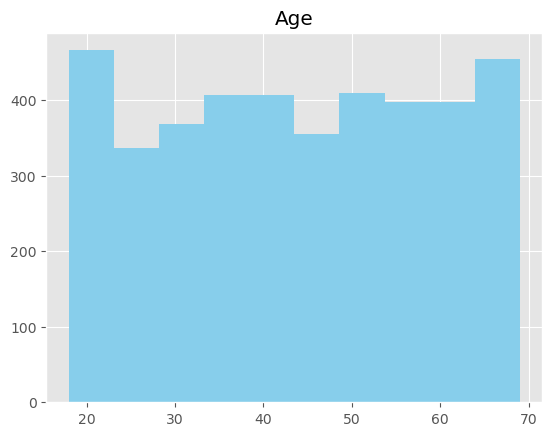

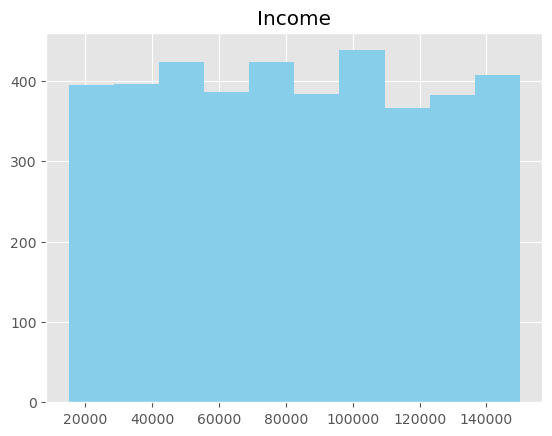

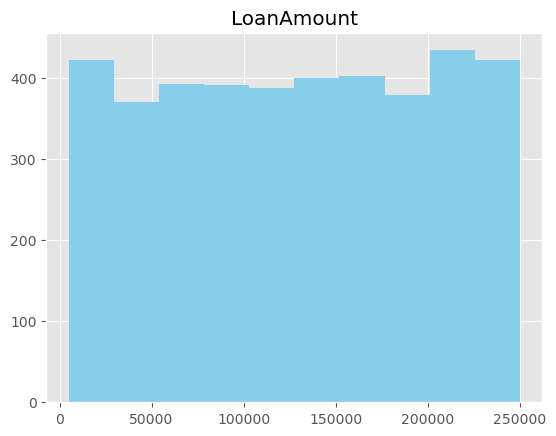

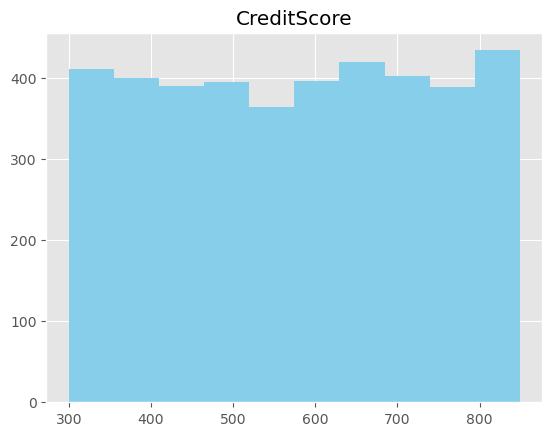

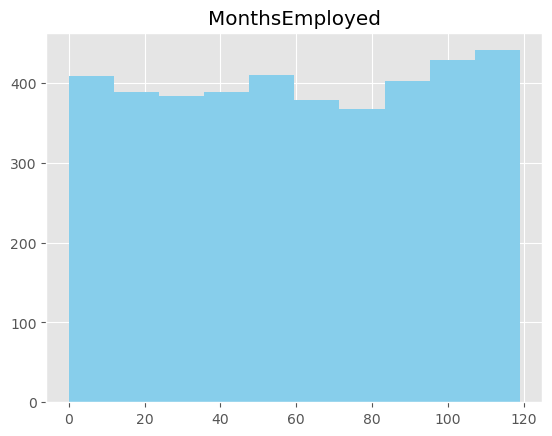

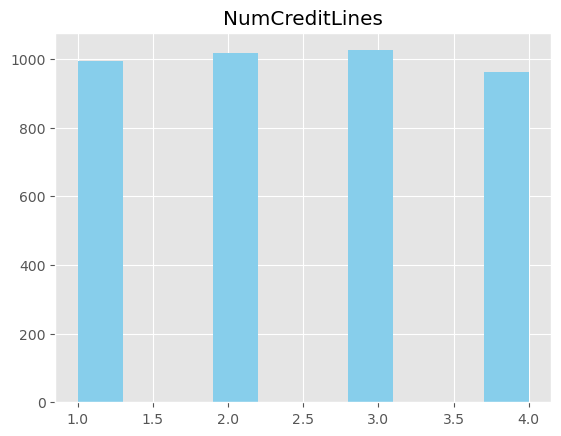

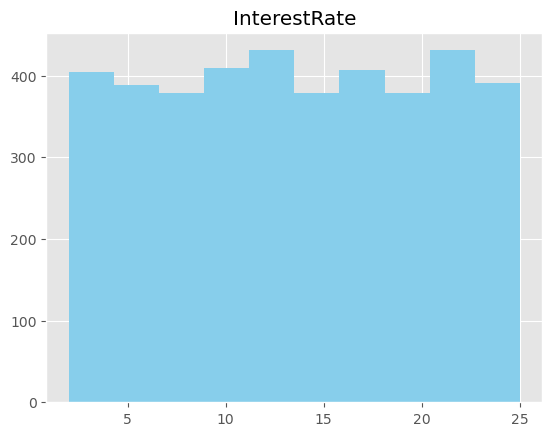

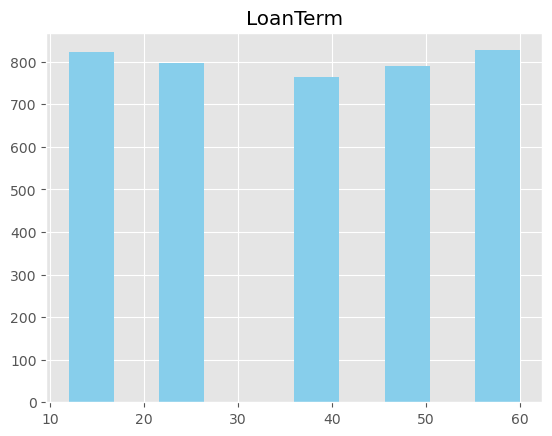

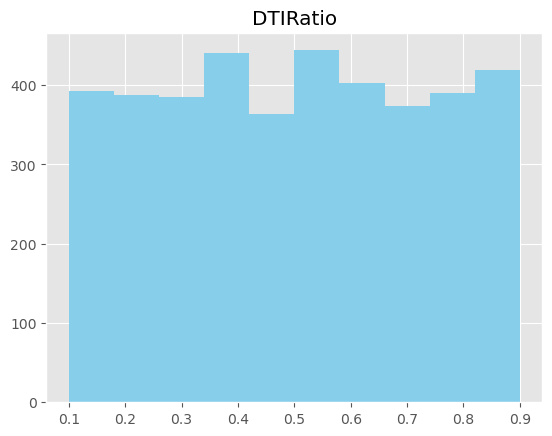

In [6]:
# Plot histograms for all numerical categories
for i in data_num.columns:
    plt.style.use('ggplot')
    plt.hist(data_num[i], color = 'skyblue')
    plt.title(i)
    plt.show()

None of the numerical categories appear to have a normal distribution. 

                     Age    Income  LoanAmount  CreditScore  MonthsEmployed  \
Age             1.000000 -0.004972    0.002118    -0.026053        0.003219   
Income         -0.004972  1.000000   -0.021905    -0.029889        0.022537   
LoanAmount      0.002118 -0.021905    1.000000     0.017763       -0.006339   
CreditScore    -0.026053 -0.029889    0.017763     1.000000       -0.011108   
MonthsEmployed  0.003219  0.022537   -0.006339    -0.011108        1.000000   
NumCreditLines  0.009683  0.021627    0.000289    -0.004403        0.023076   
InterestRate   -0.021150 -0.010962   -0.008043     0.001030       -0.018372   
LoanTerm       -0.012020 -0.002650    0.004029    -0.010219        0.009450   
DTIRatio        0.005962  0.011323   -0.023500     0.007407       -0.002663   

                NumCreditLines  InterestRate  LoanTerm  DTIRatio  
Age                   0.009683     -0.021150 -0.012020  0.005962  
Income                0.021627     -0.010962 -0.002650  0.011323  
LoanAmou

Text(0.5, 1.0, 'Heatmap with range 0 to 1')

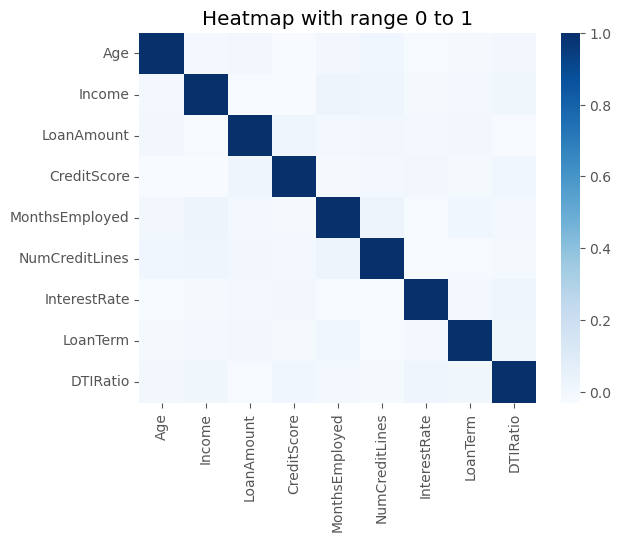

In [7]:
# Heatmap of the numerical categories.
print(data_num.corr())
sns.heatmap(data_num.corr(), cmap="Blues").set_title('Heatmap with range 0 to 1')

Text(0.5, 1.0, 'Heatmap with range 0 to 0.05')

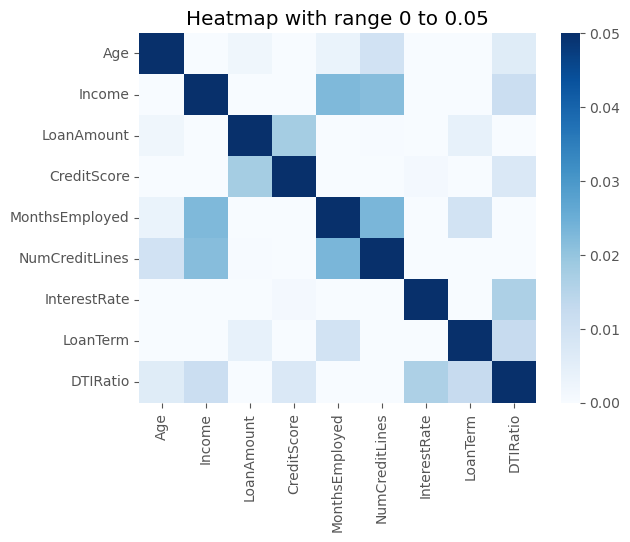

In [8]:
sns.heatmap(data_num.corr(), cmap="Blues",vmin=0, vmax=0.05).set_title('Heatmap with range 0 to 0.05')

None of the numerical categories appear to have much correlation with each other in the default heatmap, but reducing the maximum value in the color bar allows us to see that there is a slightly higher correlation between a few of the categories.

In [9]:
# Pivot table comparing Default and the numerical values
pd.pivot_table(data_sample, index = 'Default', values = ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio'])

,Age,CreditScore,DTIRatio,Income,InterestRate,LoanAmount,LoanTerm,MonthsEmployed,NumCreditLines
Default,,,,,,,,,
0,44.630533,578.853008,0.493539,83515.729285,13.208048,126774.797957,35.914869,61.663734,2.476447
1,37.319328,558.880252,0.526113,72781.313025,15.948466,144880.764706,36.630252,50.289916,2.581933


Customers who did not default on average were older, had a higher credit score, lower debt to income ration, higher income, a lower interest rate on their loan, a smaller loan, a shorter loan term, longer employment history, and fewer credit lines.

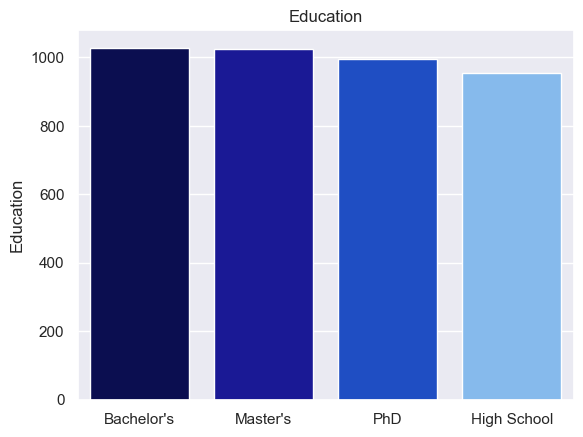

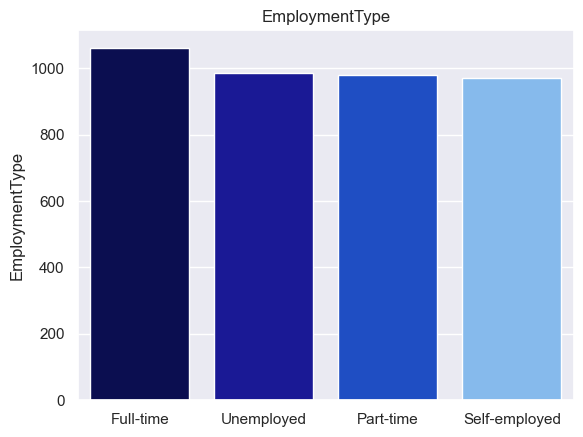

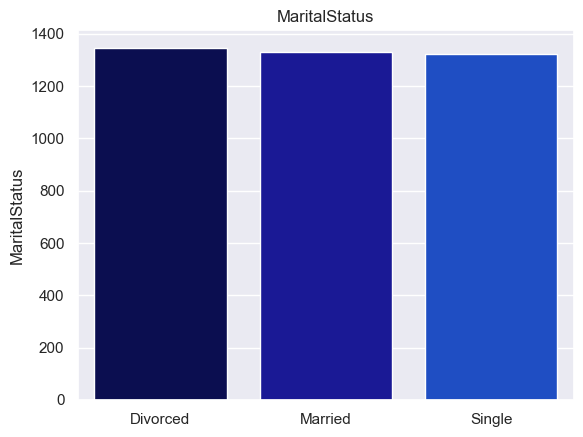

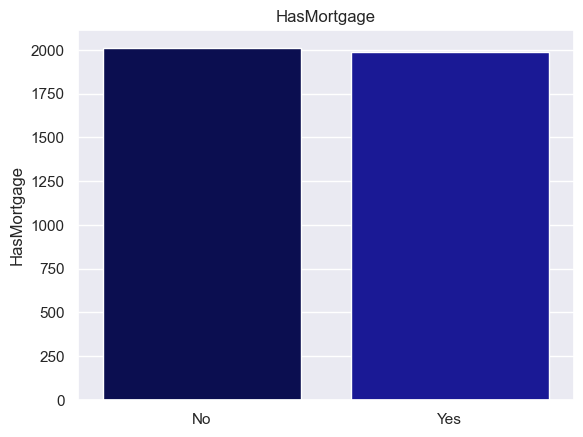

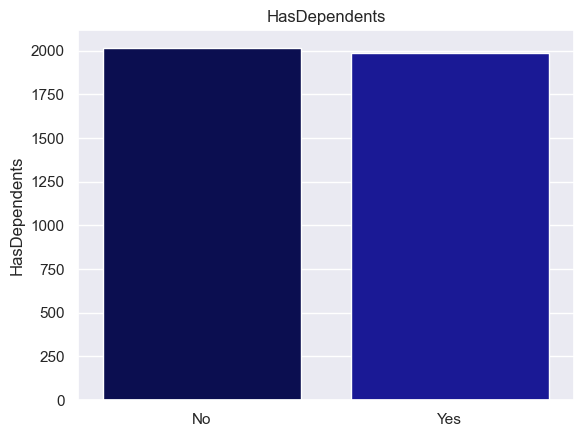

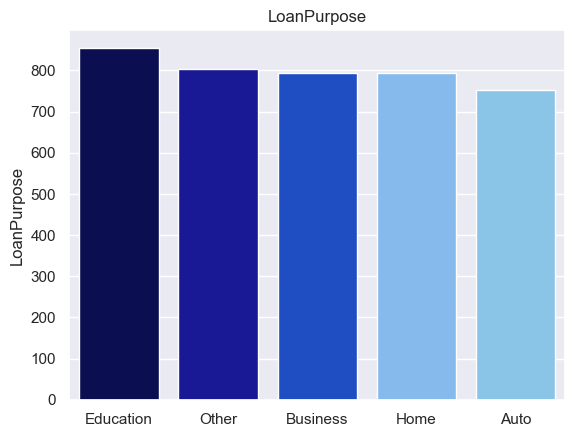

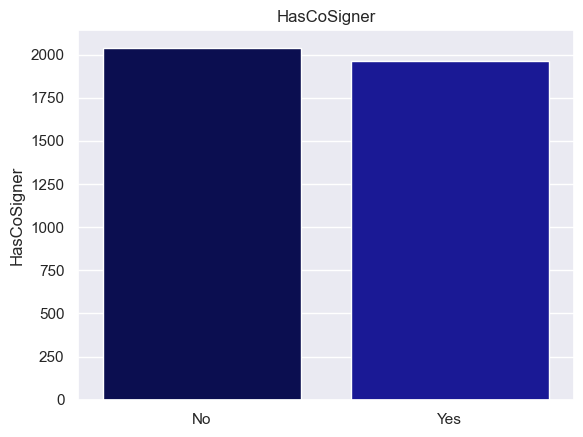

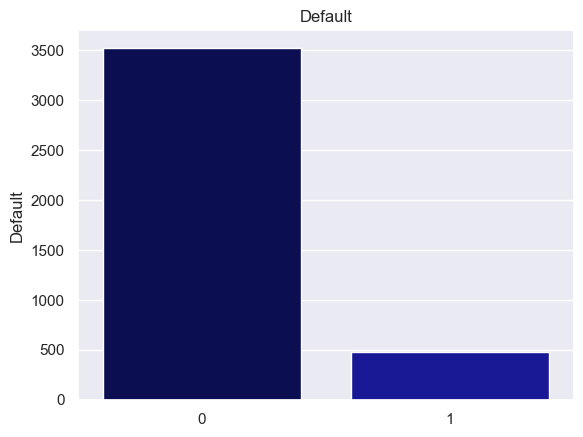

In [10]:
# Creating bar plots for all categorical columns
for i in data_cat.columns:
    # color palette can be passed as a list of hex codes
    custom_colors = ["xkcd:dark blue", "xkcd:royal blue", "xkcd:blue", "xkcd:sky blue", "xkcd:lightblue" ]
    # set overall plot style, font size scaling factor, and color palette
    sns.set(palette = custom_colors)
    sns.barplot(x=data_cat[i].value_counts().index, y=data_cat[i].value_counts()).set_title(i)
    plt.show()



In [11]:
# Pivot table comparing Default and the categorical values
print(pd.pivot_table(data_sample, index = 'Default', columns = 'Education', values = 'LoanID', aggfunc ='count'))
print('\n')
print(pd.pivot_table(data_sample, index = 'Default', columns = 'EmploymentType', values = 'LoanID', aggfunc ='count'))
print('\n')
print(pd.pivot_table(data_sample, index = 'Default', columns = 'HasMortgage', values = 'LoanID', aggfunc ='count'))
print('\n')
print(pd.pivot_table(data_sample, index = 'Default', columns = 'HasDependents', values = 'LoanID', aggfunc ='count'))
print('\n')
print(pd.pivot_table(data_sample, index = 'Default', columns = 'LoanPurpose', values = 'LoanID', aggfunc ='count'))
print('\n')
print(pd.pivot_table(data_sample, index = 'Default', columns = 'HasCoSigner', values = 'LoanID', aggfunc ='count'))

Education  Bachelor's  High School  Master's  PhD
Default                                          
0                 912          812       917  883
1                 116          141       107  112


EmploymentType  Full-time  Part-time  Self-employed  Unemployed
Default                                                        
0                     964        850            862         848
1                      98        130            109         139


HasMortgage    No   Yes
Default                
0            1768  1756
1             244   232


HasDependents    No   Yes
Default                  
0              1743  1781
1               273   203


LoanPurpose  Auto  Business  Education  Home  Other
Default                                            
0             661       687        748   720    708
1              92       108        107    74     95


HasCoSigner    No   Yes
Default                
0            1770  1754
1             269   207


In all categories, except Default, the data are evenly distributed.  

Data processing:
<br>
    1. There are no null or incorrectly typed values that need to be fixed prior to modeling
    <br>
    2. Exclude LoanID so that only relevant information is processed by the models
    <br>
    3. Encode all categorical variables
    <br>
    4. Using a Random Forest Regressor, find the most signifigant features. This is done by calculating how many trees each feature would be included in in a random forest model.
    

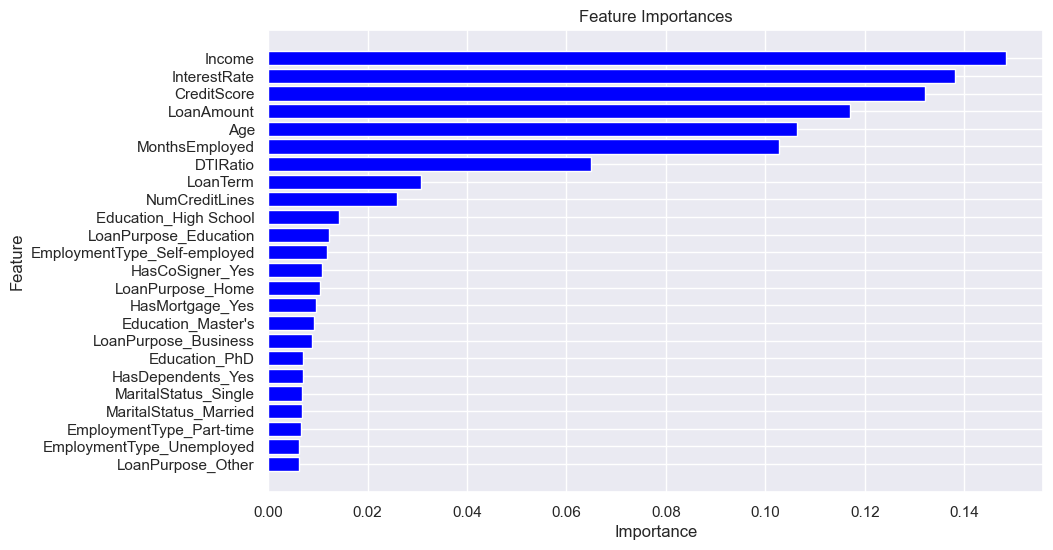

In [12]:
data_train, data_test = train_test_split(data_sample, test_size=0.3)

# Selecting X and y and excluding irrelevalnt columns (LoanID). This is done will the full data set. Test and train will be split again after scaling, ancoding, etc.
X_train_pre = data_train.drop(['Default','LoanID'], axis=1)
y_train = data_train.Default
X_test_pre = data_test.drop(['Default','LoanID'], axis=1)
y_test = data_test.Default

# Use one-hot encode all categorical columns. 
# After encoding allows all the columns to be compared with a Random Forest regressor to see which features are the most signifigant and should be used in the model.
X_encoded = pd.get_dummies(X_train_pre, columns=X_train_pre.select_dtypes(include=['object']).columns, drop_first=True)

rf_regressor = RandomForestRegressor(n_estimators=10, random_state=42)
rf_regressor.fit(X_encoded, y_train)
feature_importances = rf_regressor.feature_importances_


importance_df = pd.DataFrame({'Feature': X_encoded.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='blue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  
plt.show()


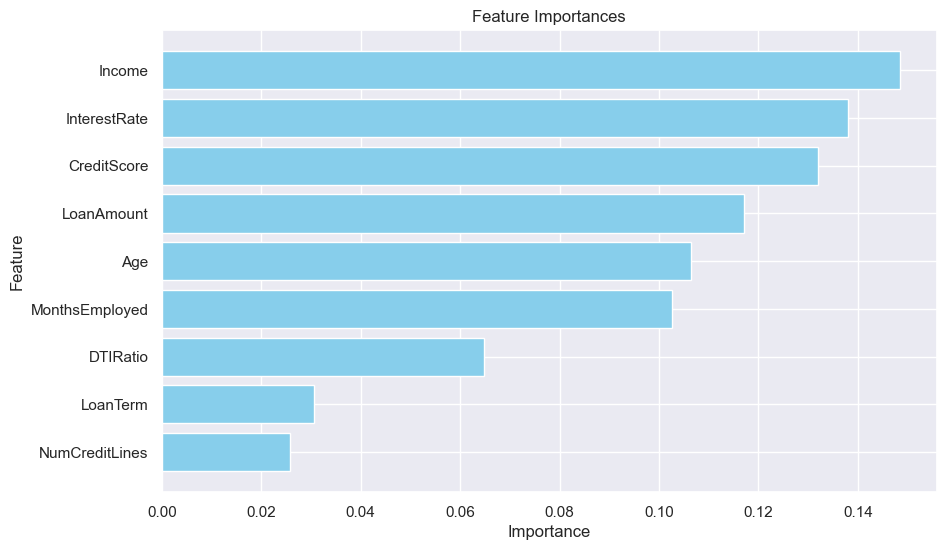

In [13]:
# Removing all features with an Importance rating of less than 0.2
importance_df = importance_df.loc[lambda x: x['Importance'] >= 0.02]

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  
plt.show()

In [14]:
# Dropping the columns with low Importance ratings from train and test.
X_train_unscaled = X_train_pre.drop(['LoanPurpose','MaritalStatus', 'Education', 'EmploymentType', 'HasMortgage', 'HasDependents', 'HasCoSigner'], axis=1)
X_test = X_test_pre.drop(['LoanPurpose','MaritalStatus', 'Education', 'EmploymentType', 'HasMortgage', 'HasDependents', 'HasCoSigner'], axis = 1)


In [15]:
# Using Synthetic Minority Over-Sampling Technique SMOTE to balance the Default category. 
# Prior to using smote the data are in an approximately 90/10 split. 
# After SMOTE synthetic positive Default datapoints are added so the dataset is 50/50.

smote = SMOTE(random_state=20)
X_resampled, y_train = smote.fit_resample(X_train_unscaled, y_train) 


In [16]:
y_train.describe()


count    4960.00000
mean        0.50000
std         0.50005
min         0.00000
25%         0.00000
50%         0.50000
75%         1.00000
max         1.00000
Name: Default, dtype: float64

In [17]:
# Scaling the data so that categories like Income and Loan ammount are not disproportionately represented.

scale = StandardScaler()

X_train = X_resampled.copy()
X_train[['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio']] = scale.fit_transform(X_train[['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio']])
X_test = X_test.copy()
X_test[['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio']] = scale.fit_transform(X_test[['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio']])



# Using OneHotEncoder to encode all categorical data as numerical.
X_train = pd.get_dummies(X_train, columns=X_train.select_dtypes(include=['object']).columns, drop_first=True)
X_test = pd.get_dummies(X_test, columns=X_test.select_dtypes(include=['object']).columns, drop_first=True)

Since the none of the data in the training set is normal we will primarily focus on machine learning models that do not assume gaussian distribution.
For the first pass we will do 5 fold baseline cross validation with several models without any performance tuning. 

The models used in this baseline analysis will be:

1. SVC
2. Decision Tree
3. Random Forest
4. KNN
5. XGBoost

In [18]:
# Support Vector Machine
svc = SVC(probability = True)
cv = cross_val_score(svc, X_train, y_train, cv = 5)
print(cv)
print(cv.mean())

[0.74798387 0.83266129 0.83870968 0.83568548 0.81955645]
0.8149193548387096


In [19]:
# Decision Tree
dt = tree.DecisionTreeClassifier(random_state = 1)
cv = cross_val_score(dt, X_train, y_train, cv = 5)
print(cv)
print(cv.mean())

[0.75403226 0.85181452 0.85987903 0.86895161 0.85383065]
0.8377016129032258


In [20]:
# Random Forest
rf = RandomForestClassifier(random_state = 1)
cv = cross_val_score(rf, X_train, y_train, cv = 5)
print(cv)
print(cv.mean())

[0.81451613 0.93245968 0.94556452 0.92943548 0.92237903]
0.9088709677419355


In [21]:
# K Nearest Neighbors
knn = KNeighborsClassifier()
cv = cross_val_score(knn, X_train, y_train, cv = 5)
print(cv)
print(cv.mean())

[0.79334677 0.82157258 0.81854839 0.80745968 0.80141129]
0.808467741935484


In [22]:
# Xtreme Gradient Boosting
xgb = XGBClassifier(random_state =1)
cv = cross_val_score(xgb, X_train, y_train, cv = 5)
print(cv)
print(cv.mean())

[0.79133065 0.94254032 0.9516129  0.94858871 0.94858871]
0.9165322580645162


All models performed well with base parameters, however XGBoost and Random Forest had the best results before tuning. The next setp is to try to improve the performance by tuning the parameters.

In [23]:
# Selecting the best parameters and the best score using those parameters
def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score: ' + str(classifier.best_score_))
    print('Best Parameters: ' + str(classifier.best_params_))

In [24]:
# Support Vector Machine
svc = SVC(probability = True)
param_grid = tuned_parameters = [{ 'kernel' : ['rbf', 'linear'],
                                   'gamma' : [0.001, .01, .1, 1],
                                   'C' : [0.01, 0.1, 1, 10, 100] }]
clf_svc = GridSearchCV(svc, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_svc = clf_svc.fit(X_train, y_train)
clf_performance(best_clf_svc, 'SVC')



Fitting 5 folds for each of 40 candidates, totalling 200 fits
SVC
Best Score: 0.9375
Best Parameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}


In [25]:
# Decision Tree
dt = tree.DecisionTreeClassifier(random_state = 1)
param_grid =  {'criterion':['gini', 'entropy', 'log_loss'],
               'max_depth': [25, 50, 75, 100],
               'min_samples_split': [2,3],
               'min_samples_split': [2,3]}
clf_dt = GridSearchCV(dt, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_dt = clf_dt.fit(X_train, y_train)
clf_performance(best_clf_dt, 'DT')

Fitting 5 folds for each of 24 candidates, totalling 120 fits
DT
Best Score: 0.8445564516129032
Best Parameters: {'criterion': 'entropy', 'max_depth': 50, 'min_samples_split': 3}


In [26]:
#Using a randomized search to narrow down the paramters for Random Forest. The results of this will be used to test again with a smaller set of parameter options

rf = RandomForestClassifier(random_state = 1)
param_grid =  {'n_estimators': [100,500,1000, 1500], 
                                  'bootstrap': [True,False],
                                  'max_depth': [3,5,10,20,50,75,100,None],
                                  'min_samples_leaf': [1,2,4,10],
                                  'min_samples_split': [2,5,10]}
                                  
clf_rf_rnd = RandomizedSearchCV(rf, param_distributions = param_grid, n_iter = 50, cv = 5, verbose = True, n_jobs = -1)
best_clf_rf_rnd = clf_rf_rnd.fit(X_train,y_train)
clf_performance(best_clf_rf_rnd,'Random Forest')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Random Forest
Best Score: 0.9106854838709678
Best Parameters: {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None, 'bootstrap': False}


In [27]:
# Random Forest
rf = RandomForestClassifier(random_state = 1)
param_grid =  {'n_estimators': [500,1000, 1500],
               'criterion':['gini'],
               'bootstrap': [False],
               'max_depth': [5, 25, 50, None],
               'min_samples_leaf': [1,2],
               'min_samples_split': [2,3]}
                                  
clf_rf = GridSearchCV(rf, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_rf = clf_rf.fit(X_train,y_train)
clf_performance(best_clf_rf,'Random Forest')

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Random Forest
Best Score: 0.9171370967741936
Best Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}


In [28]:
# K Nearest Neighbors
knn = KNeighborsClassifier()
param_grid = {'n_neighbors' : [3,5,7,9],
              'weights' : ['uniform', 'distance'],
              'algorithm' : ['auto', 'ball_tree', 'kd_tree'],
              'p' : [1,2]}
clf_knn = GridSearchCV(knn, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_knn = clf_knn.fit(X_train, y_train)
clf_performance(best_clf_knn, 'KNN')

Fitting 5 folds for each of 48 candidates, totalling 240 fits
KNN
Best Score: 0.8387096774193548
Best Parameters: {'algorithm': 'auto', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}


In [29]:
# Randomized parameter selection for XGBoost
xgb = XGBClassifier(random_state = 1)

param_grid = {
   'n_estimators': [50, 100, 250, 500, 1000],
   'colsample_bytree': [0.2, 0.5, 0.7, 1],
   'max_depth': [2, 5, 10, 20, None],
   'reg_alpha': [0, 0.5, 1],
   'reg_lambda': [1, 1.5, 2],
   'subsample': [0.5,0.7, 0.9],
   'learning_rate':[.01,0.1,0.5,0.9],
   'gamma':[0, .01, .1, 1, 10, 100],
   'min_child_weight':[0,.01,0.1,1,10],
   'eval_metric': ['logloss', 'error', 'aucpr']
}

clf_xgb_rnd = RandomizedSearchCV(xgb, param_distributions = param_grid, n_iter = 50, cv = 5, verbose = True, n_jobs = -1)
best_clf_xgb_rnd = clf_xgb_rnd.fit(X_train,y_train)
clf_performance(best_clf_xgb_rnd,'XGB')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
XGB
Best Score: 0.9258064516129032
Best Parameters: {'subsample': 0.9, 'reg_lambda': 1.5, 'reg_alpha': 1, 'n_estimators': 500, 'min_child_weight': 0.1, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0.01, 'eval_metric': 'error', 'colsample_bytree': 0.7}


In [30]:
# XGBoost
xgb = XGBClassifier(random_state = 1)

param_grid = {
    'n_estimators': [500],
    'colsample_bytree': [0.7],
    'max_depth': [20],
    'reg_alpha': [0.0],
    'reg_lambda': [1, 2],
    'subsample': [0.7, 0.9],
    'learning_rate': [0.9, 1],
    'gamma':[0.0],
    'min_child_weight':[0.0, 0.1],
    'eval_metric': ['logloss', 'error', 'aucpr']
}

clf_xgb = GridSearchCV(xgb, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_xgb = clf_xgb.fit(X_train,y_train)
clf_performance(best_clf_xgb,'XGB')

Fitting 5 folds for each of 48 candidates, totalling 240 fits
XGB
Best Score: 0.9278225806451612
Best Parameters: {'colsample_bytree': 0.7, 'eval_metric': 'logloss', 'gamma': 0.0, 'learning_rate': 0.9, 'max_depth': 20, 'min_child_weight': 0.0, 'n_estimators': 500, 'reg_alpha': 0.0, 'reg_lambda': 1, 'subsample': 0.9}


All five models will be used to predict y_hat. If the results of this project depended only on the Best Score metric then XGBoost and SVM would be the best options, but the Best Score metric does not necessicarily reflect the model that will predict y_hat best with X_test.

In [31]:
# Make Predictions 

y_hat_knn = best_clf_knn.predict(X_test).astype(int)
y_hat_svc = best_clf_svc.predict(X_test).astype(int)
y_hat_rf = best_clf_rf.predict(X_test).astype(int)
y_hat_xgb = best_clf_xgb.predict(X_test).astype(int)
y_hat_dt = best_clf_dt.predict(X_test).astype(int)

In [32]:
# Printing evaluation metrics for each model
def eval_metrics(y_hat, model_name):
    print(model_name)
    accuracy_ = accuracy_score(y_test, y_hat)
    precision_ = precision_score(y_test, y_hat)
    recall_ = recall_score(y_test, y_hat)
    roc_auc_ = roc_auc_score(y_test, y_hat)
    f1_ = f1_score(y_test, y_hat)
    print("Test Accuracy:", accuracy_)
    print("Test Precision:", precision_)
    print("Test Recall:", recall_)
    print("Test ROC AUC:", roc_auc_)
    print("Test F1:", f1_)

Support Vector Machine was the most accuarate by far, but a comparatively very low F1 score. This is due to SVM correctly identifying a large number of true negatives in the test set, but only a small number of true positives.
F1 is defined as:
$$
F1 = \frac{2*TP}{2*TP + FP + FN}
$$
where TP is true positive, FP is false positive, and FN is false negative.

The remaining 4 models all have very low scores for accuracy and precision. This is likely due to the calibration loss caused by using SMOTE to balance the training data. In the confusion matricees later in the report we can see that all four models, except SVM, predicted nearly a 50/50 split between the two classes when the test data was actually closer to 90/10. 

In [33]:
eval_metrics(y_hat_svc, 'SVM')
eval_metrics(y_hat_dt, 'DT')
eval_metrics(y_hat_rf, 'RF')
eval_metrics(y_hat_knn, 'KNN')
eval_metrics(y_hat_xgb, 'XGB')

SVM
Test Accuracy: 0.8075
Test Precision: 0.1559633027522936
Test Recall: 0.10897435897435898
Test ROC AUC: 0.5104258768051871
Test F1: 0.12830188679245283
DT
Test Accuracy: 0.4675
Test Precision: 0.14432989690721648
Test Recall: 0.6282051282051282
Test ROC AUC: 0.5358458591217212
Test F1: 0.23473053892215567
RF
Test Accuracy: 0.6316666666666667
Test Precision: 0.1643192488262911
Test Recall: 0.44871794871794873
Test ROC AUC: 0.5538608900677866
Test F1: 0.2405498281786942
KNN
Test Accuracy: 0.59
Test Precision: 0.164
Test Recall: 0.5256410256410257
Test ROC AUC: 0.5626289419392867
Test F1: 0.25
XGB
Test Accuracy: 0.38333333333333336
Test Precision: 0.13950617283950617
Test Recall: 0.7243589743589743
Test ROC AUC: 0.5283672266430888
Test F1: 0.23395445134575568


In [34]:
#  Convert the output of the predictions to a DataFrame

final_data = {'LoanID': data_test.LoanID, 'Default': y_hat_svc}
submission = pd.DataFrame(data=final_data)

final_data_2 = {'LoanID': data_test.LoanID, 'Default': y_hat_dt}
submission_2 = pd.DataFrame(data=final_data_2)

final_data_3 = {'LoanID': data_test.LoanID, 'Default': y_hat_rf}
submission_3 = pd.DataFrame(data=final_data_3)

final_data_4 = {'LoanID': data_test.LoanID, 'Default': y_hat_knn}
submission_4 = pd.DataFrame(data=final_data_4)

final_data_5 = {'LoanID': data_test.LoanID, 'Default': y_hat_xgb}
submission_5 = pd.DataFrame(data=final_data_5)

final_data_comp = {'LoanID': data_test.LoanID, 'Default': data_test.Default, 'Default_svm': y_hat_svc, 'Default_dt': y_hat_dt, 'Default_rf': y_hat_rf, 'Default_knn': y_hat_knn, 'Default_xgb': y_hat_xgb}
comparison = pd.DataFrame(data=final_data_comp)

In [35]:
comparison.describe()

,Default,Default_svm,Default_dt,Default_rf,Default_knn,Default_xgb
count,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.00000
mean,0.130000,0.090833,0.565833,0.355000,0.416667,0.67500
std,0.336444,0.287492,0.495854,0.478713,0.493212,0.46857
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,1.00000
75%,0.000000,0.000000,1.000000,1.000000,1.000000,1.00000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


Confusion Matrices where:
<br>
     True Negative: C<sub>0,0</sub>
    <br>
     False negatives: C<sub>1,0</sub> 
    <br>
     True positive: C<sub>1,1</sub>
    <br>
     False positive: C<sub>0,1</sub>.

In [37]:
#Confusion matrices for all 5 models.

print('\nConfusion Matrix - SVM')
print(confusion_matrix(comparison['Default_svm'], comparison['Default']))
print('\nConfusion Matrix - DT')
print(confusion_matrix(comparison['Default_dt'], comparison['Default']))
print('\nConfusion Matrix - RF')
print(confusion_matrix(comparison['Default_rf'], comparison['Default']))
print('\nConfusion Matrix - KNN')
print(confusion_matrix(comparison['Default_knn'], comparison['Default']))
print('\nConfusion Matrix - XGB')
print(confusion_matrix(comparison['Default_xgb'], comparison['Default']))




Confusion Matrix - SVM
[[952 139]
 [ 92  17]]

Confusion Matrix - DT
[[463  58]
 [581  98]]

Confusion Matrix - RF
[[688  86]
 [356  70]]

Confusion Matrix - KNN
[[626  74]
 [418  82]]

Confusion Matrix - XGB
[[347  43]
 [697 113]]


## Conclusions

While SVM produced the most accurate results for this project, for real world application it may not be the best option. This project limited the training data to a small subset of the available 250k data points to improve speed, but this is not a realistic strategy when training a production model. Since SVM does produce better results with SMOTE, a 250k entry data set with a 90/10 split would become a 450k entry training set (225k of the majority class, 25k real entries for the minority class, and 200k synthetic entries for the minority class.) Taking into consideration the actual delinquency rate for loans in the US, which is currently around 1.5% and peaked at 7.5% following the 2008 housing crisis, the number of synthetic data points required to balance the training data SVM quickly becomes too computationally intensive to be useful in this use case.

For a production loan default predictor, we would recommend using one of the "stronger" models like XGBoost, Random Forest, or even a deep learning model. However instead of applying SMOTE, the imbalanced classes can be addressed with cost-sensitive learning or weighting the classes in model tuning.